Guiding question: How accurately can I predict GDP of a country, without knowing the country name, based solely on political, environmental, financial, and health data? For the USA, how accurately can I forecast GDP by percent change and GDP in dollars?

Imports Below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2


from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

Accessing cleaned USA GDP data with no extra features:

In [2]:
X_USA = pd.read_csv("Data/Cleaned_USA_GDP_no_extra_featues.csv")
X_USA = X_USA.drop(columns = "Unnamed: 0")

Create my X and y and my train test split:

In [3]:
X = X_USA["date"]
y = X_USA["GDP growth (annual %)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

Function to display my time series predictions:

In [4]:
def plot_SARIMA_predictions(y_train, y_test = None, train_preds = None, test_preds = None, lower_conf_int = None, upper_conf_int = None, title = "Title", ylabel = "{y_label}",xlabel = "year"):
    plt.figure(figsize=(12,5))
    plt.xticks(rotation = 70)
    plt.title(title)

    # train data
    plt.plot(y_train.index, y_train, lw=1, color='purple', ls='solid', label='Train Data')

    # train prediction
    if train_preds is not None:
        plt.plot(train_preds.index, train_preds, lw=1, color='green', ls='dashed', label='Training Predictions')

    # test data
    if y_test is not None:
        plt.plot(y_test.index, y_test, lw=1, color='blue', ls='solid',label='Test Data')

    # test predictions
    if test_preds is not None:
        plt.plot(test_preds.index, test_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')

    #  labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # confidence intervals
    if lower_conf_int is not None and upper_conf_int is not None:
        plt.fill_between(y_test.index, lower_conf_int, upper_conf_int, color='k', alpha=0.1,  label ="95% conf. int.");
    # legend
    plt.legend(loc = "upper left");


Searching for best stepwise and seasonal order for my arima model

In [5]:
stepwise_sarima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 4, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=232.604, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=218.318, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=231.505, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=215.046, Time=0.03 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=209.752, Time=0.05 sec
 ARIMA(1,1,0)(3,1,1)[4]             : AIC=210.414, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=212.034, Time=0.03 sec
 ARIMA(2,1,0)(3,1,0)[4]             : AIC=211.296, Time=0.06 sec
 ARIMA(1,1,1)(3,1,0)[4]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(3,1,0)[4]             : AIC=202.722, Time=0.06 sec
 ARIMA(0,1,1)(2,1,0)[4]             : AIC=203.817, Time=0.05 sec
 ARIMA(0,1,1)(3,1,1)[4]             : AIC=inf, Time=0.23 sec
 ARIMA(0,1,1)(2,1,1)[4]             : AIC=inf, Time=0.22 sec
 A

In [6]:
stepwise_sarima.order, stepwise_sarima.seasonal_order

((0, 1, 1), (3, 1, 0, 4))

Fitting my Arima Model using best setpwise and seasonal order

In [7]:
order = (0, 1, 1)
seasonal_order = (3, 1, 0, 4)

# instantiate
model_sarima = SARIMAX(
    y_train, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
fitted_model_sarima = model_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
# fitted_tour_sarima = tour_sarima.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

preds_ar_1 = fitted_model_sarima.predict(#params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

Creating my 95% confidence interval on my forcasting predictions:

In [8]:
# get forecast object
forecast_object = fitted_model_sarima.get_forecast(steps = len(y_test))

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

Converting the index of the data back to years:

In [9]:
y_train.index = pd.RangeIndex(start= 1961, stop = 2008)
y_test.index = pd.RangeIndex(start=2008, stop = 2020)  
preds_ar_1.index = pd.RangeIndex(start=2008, stop = 2020)  

Plotting my time series predictions for USA GDP percent change VS. actual USA GDP percent change:

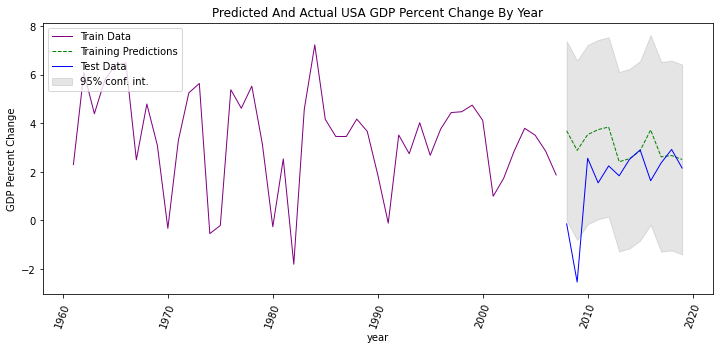

In [10]:
# plotting .get_forecast
plot_SARIMA_predictions(
    y_train, 
    y_test,
    preds_ar_1,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "Predicted And Actual USA GDP Percent Change By Year",
    ylabel = "GDP Percent Change"
)

Root Mean Squared Error and R2 Score Print Out For USA GDP Percent Change:

In [11]:
print (f'Root Mean Square Error = {(mean_squared_error(y_test, preds_ar_1)) ** .5} , R2 Score = {r2_score(y_test, preds_ar_1)}')

Root Mean Square Error = 2.188006410650277 , R2 Score = -1.1502377324087756


Predicting GDP Percent Change one year forward and taking each previous year's data into account

In [12]:
# Set up the orders
order = (0, 1, 1)
seasonal_order = (3, 1, 0, 4)


# storing new test predictions, the history, and confidence intervals
temp_test_preds = []
history = y_train.values
conf_ints = []

# for each test observation...
for val in y_test:
    # create model
    sarima = SARIMAX(history, order = order, seasonal_order = seasonal_order, enforce_stationarity = False)
    # fit
    fitted_sarima = sarima.fit(method = "powell", maxiter = 200, disp = 0) # stop excessive ouput with disp = 0
    # make next out-of-sample prediction
    pred_obj = fitted_sarima.get_forecast(steps = 1)
    # add to preds and conf_ints
    temp_test_preds.append(pred_obj.predicted_mean)
    conf_ints.append(pred_obj.conf_int()[0])

    # add TRUTH to history for next training
    history = np.append(history, val)

Generating my predictions

In [13]:
# setting up info for visualization
new_test_preds = pd.Series(temp_test_preds, index = y_test.index)

# converting list to numpy array for convenience
lower_conf_int = np.array(conf_ints)[:,0]
upper_conf_int = np.array(conf_ints)[:,1]

Plotting my predictions

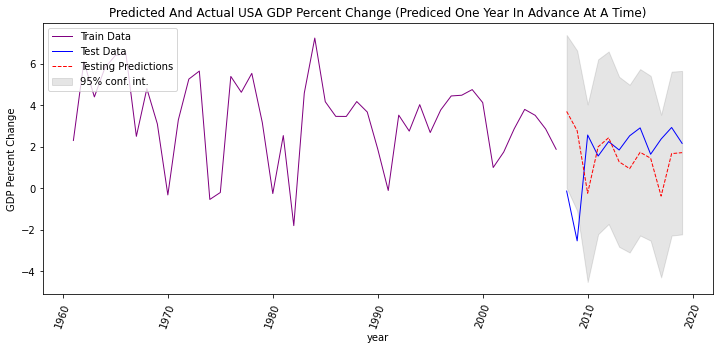

In [14]:
# plotting Multi-Step Out-of-Sample Forecasting
plot_SARIMA_predictions(
    y_train, 
    y_test,
    test_preds = new_test_preds,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "Predicted And Actual USA GDP Percent Change (Prediced One Year In Advance At A Time)",
    ylabel = "GDP Percent Change"
)

Scorring My Yearly Prediction Model For USA GDP Percent Change 

In [15]:
print (f'Root Mean Square Error = {(mean_squared_error(y_test, new_test_preds)) ** .5} , R2 Score = {r2_score(y_test, new_test_preds)}')

Root Mean Square Error = 2.3199773831556456 , R2 Score = -1.417446104708783


RUNNING THROUGH THE MODELS AGAIN TO PREDICT USA GDP IN DOLLARS

Setting up my X and y variables with y as USA GDP in Dollars

In [16]:
X = X_USA["date"]
y = X_USA["United States GDP (Dollars)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

Searching for best stepwise and seasonal order for my arima model

In [17]:
stepwise_sarima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 3,
    max_q = 3,
    start_P = 0,
    start_Q = 0,
    max_P = 3,
    max_Q = 3,
    d = 1, # we know how much to difference, so don't need to waste time searching for this,
    D = 1, # we know how much to difference, so don't need to waste time searching for this,
    seasonal = True, # use seasonality!
    m = 4, # MUST tell which seasonal period to use
    trace=True,
    error_action='ignore',  # don't want to know if an order does not work
    suppress_warnings=True  # don't want convergence warnings
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=2278.059, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=2265.720, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=2269.592, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=2270.609, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=2266.967, Time=0.04 sec
 ARIMA(1,1,0)(1,1,1)[4]             : AIC=2266.512, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=2264.779, Time=0.02 sec
 ARIMA(1,1,0)(0,1,2)[4]             : AIC=2266.464, Time=0.05 sec
 ARIMA(1,1,0)(1,1,2)[4]             : AIC=2264.591, Time=0.09 sec
 ARIMA(1,1,0)(2,1,2)[4]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(1,1,3)[4]             : AIC=2266.360, Time=0.14 sec
 ARIMA(1,1,0)(0,1,3)[4]             : AIC=2267.768, Time=0.05 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(2,1,3)[4]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=2283.6

In [18]:
stepwise_sarima.order, stepwise_sarima.seasonal_order

((1, 1, 0), (0, 1, 1, 4))

Fitting my Arima Model using best setpwise and seasonal order

In [19]:
order = (1, 1, 0)
seasonal_order = (0, 1, 1, 4)

# instantiate
model_sarima = SARIMAX(
    y_train, 
    order = order, 
    seasonal_order = seasonal_order, 
    freq = None, # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
fitted_model_sarima = model_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
# fitted_tour_sarima = tour_sarima.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

preds_ar_2 = fitted_model_sarima.predict(#params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

Generating Confidence Interval On USA GDP Predictions

In [20]:
# get forecast object
forecast_object = fitted_model_sarima.get_forecast(steps = len(y_test))

# grab forecasted values
forecast_pred_values = forecast_object.predicted_mean
# converting to pandas Seried with proper datetime index
forecast_preds = pd.Series(forecast_pred_values, index = y_test.index)

# grab confidence intervals
pred_ci = forecast_object.conf_int()

# break out lower and upper confidence values
lower_conf_int = pred_ci.iloc[:,0]
upper_conf_int = pred_ci.iloc[:,1]

Converting the index of the data back to years:

In [21]:
y_train.index = pd.RangeIndex(start= 1961, stop = 2008)
y_test.index = pd.RangeIndex(start=2008, stop = 2020)  
forecast_preds.index = pd.RangeIndex(start=2008, stop = 2020)  

Plotting my time series predictions for USA GDP in dollars VS. actual USA GDP in dollars:

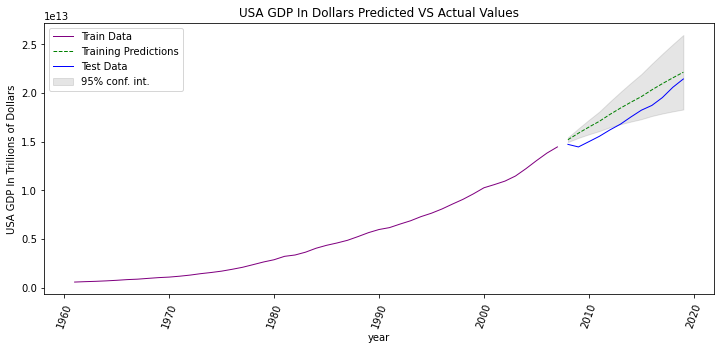

In [22]:
# plotting .get_forecast
plot_SARIMA_predictions(
    y_train, 
    y_test,
    forecast_preds,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "USA GDP In Dollars Predicted VS Actual Values",
    ylabel = "USA GDP In Trillions of Dollars"
);

In [23]:
print (f'Root Mean Square Error = {(mean_squared_error(y_test, preds_ar_2)) ** .5} , R2 Score = {r2_score(y_test, preds_ar_2)}')

Root Mean Square Error = 1365852235949.7202 , R2 Score = 0.6287433043500412


Predicting USA GDP in dollars one year forward and taking each previous year's data into account

In [24]:
# Set up the orders
order = (0, 1, 1)
seasonal_order = (3, 1, 0, 4)


# storing new test predictions, the history, and confidence intervals
temp_test_preds = []
history = y_train.values
conf_ints = []

# for each test observation...
for val in y_test:
    # create model
    sarima = SARIMAX(history, order = order, seasonal_order = seasonal_order, enforce_stationarity = False)
    # fit
    fitted_sarima = sarima.fit(method = "powell", maxiter = 200, disp = 0) # stop excessive ouput with disp = 0
    # make next out-of-sample prediction
    pred_obj = fitted_sarima.get_forecast(steps = 1)
    # add to preds and conf_ints
    temp_test_preds.append(pred_obj.predicted_mean)
    conf_ints.append(pred_obj.conf_int()[0])

    # add TRUTH to history for next training
    history = np.append(history, val)

Generating predictions and confidence interval:

In [25]:
# setting up info for visualization
new_test_preds_2 = pd.Series(temp_test_preds, index = y_test.index)

# converting list to numpy array for convenience
lower_conf_int = np.array(conf_ints)[:,0]
upper_conf_int = np.array(conf_ints)[:,1]

Plotting my time series predictions for USA GDP in dollars VS. actual USA GDP in dollars:

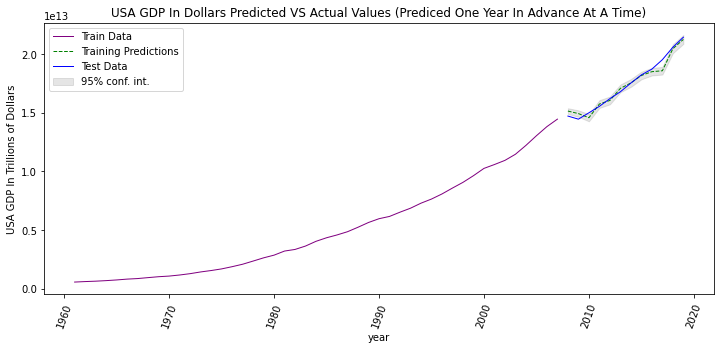

In [26]:
# plotting .get_forecast
plot_SARIMA_predictions(
    y_train, 
    y_test,
    new_test_preds_2,
    lower_conf_int = lower_conf_int,
    upper_conf_int = upper_conf_int,
    title = "USA GDP In Dollars Predicted VS Actual Values (Prediced One Year In Advance At A Time)",
    ylabel = "USA GDP In Trillions of Dollars"
);

Scoring my model

In [27]:
print (f'Root Mean Square Error = {(mean_squared_error(y_test, new_test_preds_2)) ** .5} , R2 Score = {r2_score(y_test,  new_test_preds_2)}')

Root Mean Square Error = 378972063938.6492 , R2 Score = 0.9714187477454487


Reading in new data to create in sample USA GDP percent change forecast with extraneous features added:

In [28]:
df_USA_with_extra_features = pd.read_csv("Data/cleaned_USA_data_with_multiple_features.csv")
df_USA_with_extra_features = df_USA_with_extra_features.drop(columns = "Unnamed: 0")
X = df_USA_with_extra_features.drop(columns = ["GDP growth (annual %)", "GDP (Dollars)"])
y = df_USA_with_extra_features["GDP growth (annual %)"]

Writting a gridsearch to have a more robust answer for seasonal order with extraneous features:

In [29]:
def sarimax_grid_search(endog, exog, p_range = (0,2), q_range = (0,2), P_range = (0,2), Q_range = (0,2), d = 0, D = 0, S = 12, verbose = False):
    best_aic = 99 * (10 ** 16) # a very large number
    best_order = None
    best_seasonal_order = None
    best_model = None
    # Use nested for loop to iterate over values of p and q.
    for p in range(p_range[0], p_range[1] + 1): # adding 1 so range is inclusive
        for q in range(q_range[0], q_range[1] + 1): # adding 1 so range is inclusive
            for P in range(P_range[0], P_range[1] + 1): # adding 1 so range is inclusive
                for Q in range(Q_range[0], Q_range[1] + 1): # adding 1 so range is inclusiv
                    # Insert try and except statements.
                    try:
                        # Fitting an SARIMAX(p, d, q) & (P, D, Q, S) model.
                        if verbose:
                            print(f'Attempting to fit SARIMAX({p},{d},{q}) & ({P},{D},{Q},{S})')
                        order = (p,d,q) # values of p, d, q
                        seasonal_order = (P, D, Q, S)
                        # Instantiate SARIMA model.
                        sarima = SARIMAX(endog = endog.astype(float).dropna(), # endog = Y variable
                                         exog = exog.astype(float).dropna(), # INCLUDING EXOGENOUS VARIABLES
                                      order = order,
                                      seasonal_order = seasonal_order) 

                        # Fit SARIMAX model.
                        # model = sarima.fit()
                        # If getting Convergence Errors, try increasing maxiter and changing method
                        model = sarima.fit(maxiter = 200, method = "powell", disp = 0) # disp = 0 b/c of excessive output

                        if verbose:
                            print(f'The AIC for SARIMAX({p},{d},{q})  & ({P},{D},{Q},{S}) is: {model.aic}')

                        # Is my current model's AIC better than our best_aic?
                        if model.aic < best_aic:

                            # If so, let's overwrite best found so far
                            best_aic = model.aic
                            best_order = order
                            best_seasonal_order = seasonal_order
                            best_model = model

                    except Exception as e:
                        print(e)
                        pass

    return {
        "best_aic": best_aic, 
        "best_order" : best_order, 
        "best_seasonal_order" : best_seasonal_order, 
        "best_model": best_model
    }

Running my gridsearch and printing out the best stepwise order and seasonal order

In [30]:
sarimax_gs_result = sarimax_grid_search(y, X, d = 1, D = 0, S = 7, verbose = False)

In [31]:
sarimax_gs_result

{'best_aic': 135.059421373117,
 'best_order': (2, 1, 0),
 'best_seasonal_order': (2, 0, 2, 7),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fd4d2b643a0>}

Fitting my model for in sample predictions with added features to USA GDP percent change

In [32]:
order = (2, 1, 0)
seasonal_order = (2, 0, 2, 7)

# instantiate
usa_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = "D", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
# fitted_air_sarima = air_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_usa_sarimax = usa_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

Summary printout to show the relative effect of each feature on USA percent change GDP:

In [33]:
fitted_usa_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                  GDP growth (annual %)   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(2, 0, [1, 2], 7)   Log Likelihood                  13.251
Date:                                Wed, 17 Mar 2021   AIC                             17.497
Time:                                        17:44:49   BIC                             38.275
Sample:                                             0   HQIC                            21.014
                                                 - 36                                         
Covariance Type:                                  opg                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
date                                                         2.9432      0.523      5.626      0.000       1.918       3.969
Adjusted savings: natural resources depletion (% of GNI)    -1.5986      0.661     -2.417      0.016      -2.895      -0.303
Agricultural land (% of land area)                          -0.7751      0.390     -1.985      0.047      -1.540      -0.010
CO2 emissions (metric tons per capita)                       2.6090      1.233      2.116      0.034       0.192       5.026
Energy imports, net (% of energy use)                        0.7973      0.085      9.335      0.000       0.630       0.965
Energy use (kg of oil equivalent per capita)                 0.0017      0.004      0.480      0.632      -0.005       0.009
Fertility rate, total (births per woman)                    -6.6254      2.314     -2.863      0.004     -11.161      -2.090
Food production index (2004-2006 = 100)                     -0.4119      0.113     -3.645      0.000      -0.633      -0.190
Hospital beds (per 1,000 people)                             6.9617      6.306      1.104      0.270      -5.398      19.321
Life expectancy at birth, total (years)                      3.8372      1.587      2.418      0.016       0.727       6.947
Mortality rate, under-5 (per 1,000 live births)             -6.7974      3.143     -2.162      0.031     -12.958      -0.636
Patent applications, residents                           -5.755e-05   9.76e-06     -5.894      0.000   -7.67e-05   -3.84e-05
Population ages 65 and above (% of total population)         8.9109      0.894      9.970      0.000       7.159      10.663
Population density (people per sq. km of land area)         -6.5723      1.363     -4.821      0.000      -9.244      -3.900
Prevalence of overweight (% of adults)                      -0.2378      0.768     -0.310      0.757      -1.742       1.267
ar.L1                                                       -0.9913      0.135     -7.363      0.000      -1.255      -0.727
ar.L2                                                       -0.0012      0.034     -0.035      0.972      -0.068       0.066
ar.S.L7                                                     -0.1014      0.046     -2.214      0.027      -0.191      -0.012
ar.S.L14                                                     0.2953      0.018     16.656      0.000       0.261       0.330
ma.S.L7                                                      0.0147      0.284      0.052      0.959      -0.543       0.572
ma.S.L14                                                    -0.9853      0.289     -3.415      0.001      -1.551      -0.420
sigma2                                                       0.0081      0.015      0.555      0.

Setting my starting index for my in sample predictions

In [34]:
# starting index: about 80% into dataset
starting_index = round(len(y) * .8)

Generating in sample predictions

In [35]:
GDP_preds_1 = fitted_usa_sarimax.predict(
                      start = starting_index,
                      end = y.index[-1])

Converting the index of the data back to years:

In [36]:
y.index = pd.RangeIndex(start= 1980, stop = 2016)
X.index = pd.RangeIndex(start= 1980, stop = 2016)
GDP_preds_1.index = pd.RangeIndex(start= 2009, stop = 2016)  

Plotting my time series predictions for USA GDP percent change VS. actual USA GDP percent change in sample with added features:

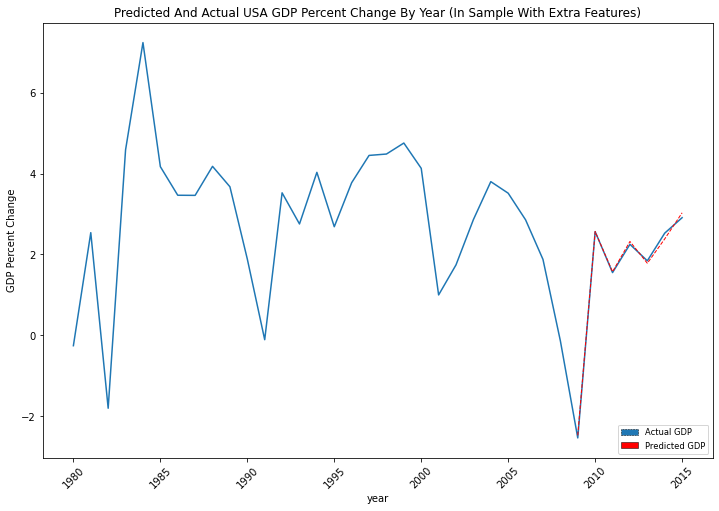

In [37]:
plt.figure (figsize=(12,8))
plt.xticks(rotation = 45)
plt.title("Predicted And Actual USA GDP Percent Change By Year (In Sample With Extra Features)")
plt.plot(X.index, y)
plt.ylabel("GDP Percent Change")
plt.xlabel("year")
plt.plot(X.index[29: 36], GDP_preds_1, lw=1, color='red', ls='dashed',label='Testing Predictions')
one = mpatches.Patch(facecolor='#1f77b4', ls='dashed', label='Actual GDP', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='red', label = 'Predicted GDP', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[one, two], loc = 4, fontsize = 'small', fancybox = True)

Scoring my model

In [38]:
print (f'Root Mean Square Error = {(mean_squared_error(y[29: 36], GDP_preds_1)) ** .5} , R2 Score = {r2_score(y[29: 36],  GDP_preds_1)}')

Root Mean Square Error = 0.08281268004812972 , R2 Score = 0.9977239427548168


Setting up X and Y for in sample USA GDP forecasts in dollars with extraneous features added:

In [39]:
X = df_USA_with_extra_features.drop(columns = ["GDP growth (annual %)", "GDP (Dollars)"])
y = df_USA_with_extra_features["GDP (Dollars)"]

Running my gridsearch and printing out the best stepwise order and seasonal order

In [40]:
# try out function on our data (with exog)
sarimax_gs_result = sarimax_grid_search(y, X, d = 1, D = 0, S = 7, verbose = False)

In [41]:
sarimax_gs_result

{'best_aic': 42.0,
 'best_order': (2, 1, 1),
 'best_seasonal_order': (1, 0, 1, 7),
 'best_model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fd4d0497070>}

Fitting my model for in sample predictions with added features to USA GDP in dollars

In [42]:
order = (2, 1, 1)
seasonal_order = (1, 0, 1, 7)

# instantiate
usa_sarimax = SARIMAX(
    y,
    X, # INCLUDING EXOGENOUS VARIABLES
    order = order, 
    seasonal_order = seasonal_order,
    #freq = "D", # freq helps set the index column of predictions
    enforce_stationarity = False # ensure model is not trying to enfore stationarity (use d and D)
)

# fit
# fitted_air_sarima = air_sarima.fit() # stats model returns fitted model

# fit, in case of convergence warning
fitted_usa_sarimax = usa_sarimax.fit(maxiter = 200, method = "powell", disp = 0) # stats model returns fitted model

Summary printout to show the relative effect of each feature on USA GDP in Dollars:

In [43]:
fitted_usa_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     GDP (Dollars)   No. Observations:                   36
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -687.154
Date:                           Wed, 17 Mar 2021   AIC                           1416.308
Time:                                   17:46:17   BIC                           1442.728
Sample:                                        0   HQIC                          1423.916
                                            - 36                                         
Covariance Type:                             opg                                         
============================================================================================================================
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
date                                                      6.559e+11   9.45e-13   6.94e+23      0.000    6.56e+11    6.56e+11
Adjusted savings: natural resources depletion (% of GNI)  2.398e+11   5.43e-13   4.41e+23      0.000     2.4e+11     2.4e+11
Agricultural land (% of land area)                        1.833e+10   1.09e-12   1.69e+22      0.000    1.83e+10    1.83e+10
CO2 emissions (metric tons per capita)                   -4.586e+10   4.21e-13  -1.09e+23      0.000   -4.59e+10   -4.59e+10
Energy imports, net (% of energy use)                    -2.516e+10   1.19e-11  -2.12e+21      0.000   -2.52e+10   -2.52e+10
Energy use (kg of oil equivalent per capita)              1.148e+09   1.84e-10   6.24e+18      0.000    1.15e+09    1.15e+09
Fertility rate, total (births per woman)                  1.146e+12   9.96e-14   1.15e+25      0.000    1.15e+12    1.15e+12
Food production index (2004-2006 = 100)                  -1.301e+10   2.56e-12  -5.08e+21      0.000    -1.3e+10    -1.3e+10
Hospital beds (per 1,000 people)                          3.736e+11   2.09e-14   1.79e+25      0.000    3.74e+11    3.74e+11
Life expectancy at birth, total (years)                   1.809e+10      6e-13   3.01e+22      0.000    1.81e+10    1.81e+10
Mortality rate, under-5 (per 1,000 live births)           1.227e+11   2.12e-13   5.78e+23      0.000    1.23e+11    1.23e+11
Patent applications, residents                            4.911e+06   7.21e-08   6.81e+13      0.000    4.91e+06    4.91e+06
Population ages 65 and above (% of total population)      1.356e+11   2.94e-13   4.61e+23      0.000    1.36e+11    1.36e+11
Population density (people per sq. km of land area)       1.138e+12   1.77e-13   6.42e+24      0.000    1.14e+12    1.14e+12
Prevalence of overweight (% of adults)                   -6.808e+11   6.27e-13  -1.08e+24      0.000   -6.81e+11   -6.81e+11
ar.L1                                                        1.2977      0.206      6.286      0.000       0.893       1.702
ar.L2                                                       -0.7596      0.197     -3.861      0.000      -1.145      -0.374
ma.L1                                                       -0.0016      0.022     -0.073      0.942      -0.045       0.041
ar.S.L7                                                      0.3321      0.139      2.383      0.017       0.059       0.605
ma.S.L7                                                      0.0018      0.001      2.242      0.025       0.000       0.003
sigma2                                                    5.237e+21   3.09e-23   1.69e+44      0.000    5.24e+21    5.24e+21
===================================================================================
Ljung-Box (L1) (Q):                   0.80   Jarque-Bera (

Setting my starting index for my in sample predictions

In [44]:
# starting index: about 80% into dataset
starting_index = round(len(y) * .8)

Generating in sample predictions

In [45]:
GDP_preds_2 = fitted_usa_sarimax.predict(
                      start = starting_index,
                      end = y.index[-1])

Converting the index of the data back to years:

In [46]:
y.index = pd.RangeIndex(start= 1980, stop = 2016)
X.index = pd.RangeIndex(start= 1980, stop = 2016)
GDP_preds_2.index = pd.RangeIndex(start= 2009, stop = 2016)  

Plotting my time series predictions for USA GDP in dollars VS. actual USA GDP in dollars in sample with added features:

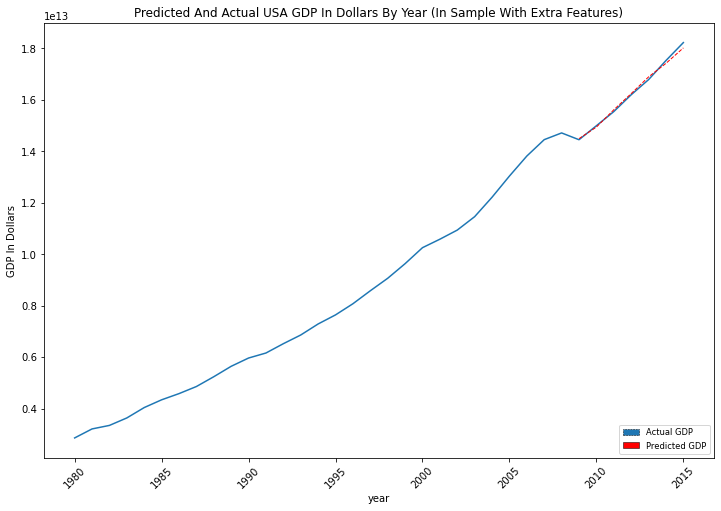

In [47]:
plt.figure (figsize=(12,8))
plt.xticks(rotation = 45)
plt.title("Predicted And Actual USA GDP In Dollars By Year (In Sample With Extra Features)")
plt.ylabel("GDP In Dollars")
plt.xlabel("year")
plt.plot(X.index, y)
plt.plot(X.index[29: 36], GDP_preds_2, lw=1, color='red', ls='dashed',label='Testing Predictions')
one = mpatches.Patch(facecolor='#1f77b4', ls='dashed', label='Actual GDP', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='red', label = 'Predicted GDP', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[one, two], loc = 4, fontsize = 'small', fancybox = True)

Scoring My Model:

In [48]:
print (f'Root Mean Square Error = {(mean_squared_error(y[29: 36], GDP_preds_2)) ** .5} , R2 Score = {r2_score(y[29: 36],  GDP_preds_2)}')

Root Mean Square Error = 104916257403.40883 , R2 Score = 0.993087055551845


Forecasting USA GDP percent change using FB Prophet and no added features:

In [49]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


Reformatting my data to fit naming conventions for forecasting with FB Prophet

In [50]:
X_USA.head()

,GDP growth (annual %),date,United States GDP (Dollars)
0,2.3,1961-01-01,5.633000e+11
1,6.1,1962-01-01,6.051000e+11
2,4.4,1963-01-01,6.386000e+11
3,5.8,1964-01-01,6.858000e+11
4,6.4,1965-01-01,7.437000e+11


In [51]:
X_USA["y"] = X_USA["GDP growth (annual %)"]
X_USA["ds"] = X_USA["date"]

Fitting my forecasting model for USA GDP percent change 

In [52]:
m = Prophet()
m.fit(X_USA.drop(columns = ["date", "United States GDP (Dollars)", "GDP growth (annual %)"]))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Creating predictions

In [53]:
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)

Displaying predictions and confidence interval in blue. Displaying actual GDP percent change values in black

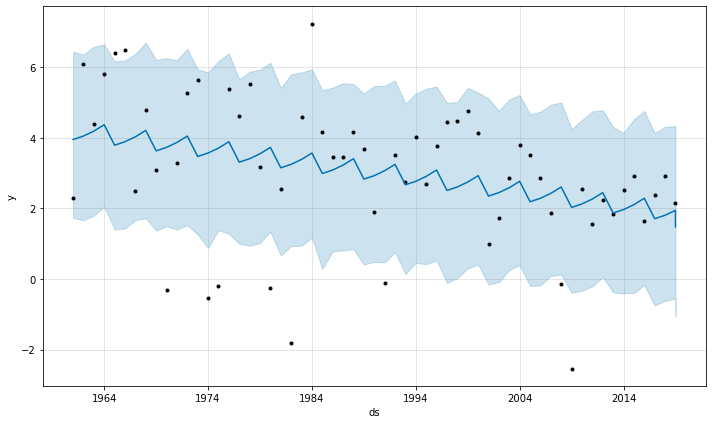

In [54]:
fig1 = m.plot(forecast)

Plotting macro trends identified by the model

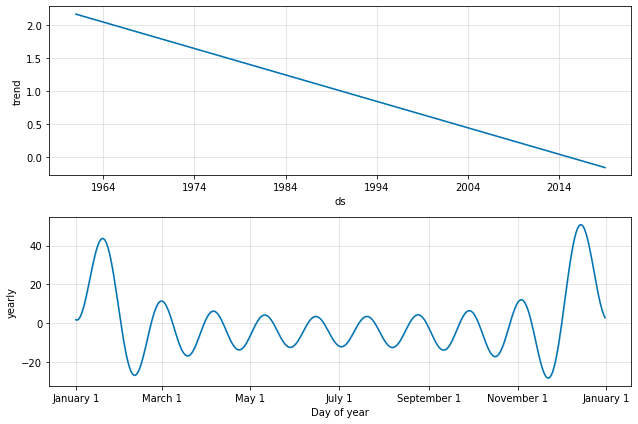

In [55]:
fig2 = m.plot_components(forecast)

In [56]:
print (f'Root Mean Square Error = {(mean_squared_error(X_USA["y"], forecast["yhat"][:-1])) ** .5} , R2 Score = {r2_score(X_USA["y"], forecast["yhat"][:-1])}')

Root Mean Square Error = 1.9005575342031003 , R2 Score = 0.12390505581644451


Forecasting USA GDP in dollars using FB Prophet and no added features:

Reformatting my data to fit naming conventions for forecasting with FB Prophet

In [57]:
X_USA["y"] = X_USA["United States GDP (Dollars)"]
X_USA["ds"] = X_USA["date"]

Fitting my forecasting model for USA GDP in dollars

In [58]:
m = Prophet()
m.fit(X_USA.drop(columns = ["date", "United States GDP (Dollars)", "GDP growth (annual %)"]))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Creating predictions

In [59]:
future = m.make_future_dataframe(periods=1)
forecast = m.predict(future)

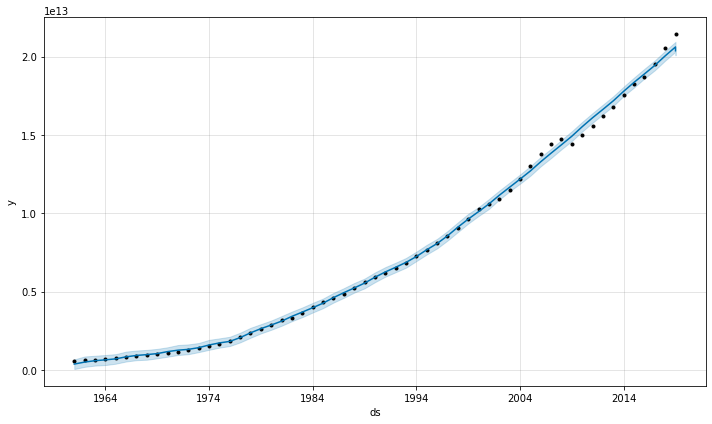

In [60]:
fig1 = m.plot(forecast)

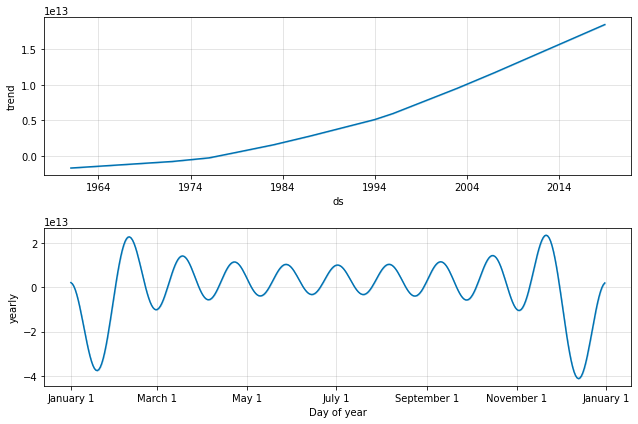

In [61]:
fig2 = m.plot_components(forecast)

In [62]:
print (f'Root Mean Square Error = {(mean_squared_error(X_USA["y"], forecast["yhat"][:-1])) ** .5} , R2 Score = {r2_score(X_USA["y"], forecast["yhat"][:-1])}')

Root Mean Square Error = 239157378235.22147 , R2 Score = 0.998531383949953
